In [28]:
\c 5 100
h:`$":tpr-mscf-kx.tepper.cmu.edu:5000:mscf2023:LZ8AByXHDaEJdTim"

In [29]:
/%python
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import jdcal
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller 
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
plt.style.use('default')

### Load Data

In [30]:
loaddata:{[s;c;sd;ed]
 / YOUR CODE HERE
 t:select date,sym,time,price,size from trade where date within (sd;ed), sym in s, cond in c;
 t}

show t_save:h (loaddata;`AAPL`NVDA`BABA;" ";2020.02.01;2020.03.01)

date       sym  time                 price  size
------------------------------------------------
2020.02.03 AAPL 0D09:30:00.104222076 304.25 200 
2020.02.03 AAPL 0D09:30:00.104222222 304.25 300 
2020.02.03 AAPL 0D09:30:00.115302599 304.16 100 
2020.02.03 AAPL 0D09:30:00.420630361 304.18 120 
2020.02.03 AAPL 0D09:30:00.425902385 304.18 100 
..


In [31]:
show t: update return:fills 0^log(prev price)%price from t_save

date       sym  time                 price  size return      
-------------------------------------------------------------
2020.02.03 AAPL 0D09:30:00.104222076 304.25 200  0           
2020.02.03 AAPL 0D09:30:00.104222222 304.25 300  0           
2020.02.03 AAPL 0D09:30:00.115302599 304.16 100  0.0002958531
2020.02.03 AAPL 0D09:30:00.420630361 304.18 120  -6.57527e-05
2020.02.03 AAPL 0D09:30:00.425902385 304.18 100  0           
..


In [32]:
t

date       sym  time                 price  size return      
-------------------------------------------------------------
2020.02.03 AAPL 0D09:30:00.104222076 304.25 200  0           
2020.02.03 AAPL 0D09:30:00.104222222 304.25 300  0           
2020.02.03 AAPL 0D09:30:00.115302599 304.16 100  0.0002958531
2020.02.03 AAPL 0D09:30:00.420630361 304.18 120  -6.57527e-05
2020.02.03 AAPL 0D09:30:00.425902385 304.18 100  0           
..


In [53]:
train_data: select from t where date < 2020.02.15
test_data: select from t where date >= 2020.02.15

In [54]:
train_data

date       sym  time                 price  size return      
-------------------------------------------------------------
2020.02.03 AAPL 0D09:30:00.104222076 304.25 200  0           
2020.02.03 AAPL 0D09:30:00.104222222 304.25 300  0           
2020.02.03 AAPL 0D09:30:00.115302599 304.16 100  0.0002958531
2020.02.03 AAPL 0D09:30:00.420630361 304.18 120  -6.57527e-05
2020.02.03 AAPL 0D09:30:00.425902385 304.18 100  0           
..


### Calculate predictability for k stocks
1. For seconds, minutes, hours frequency over D days, get MSE_i for stock i
2. return (k, n/D, 3)
3. Prediction model (average)
   - Autoregressive moving average model (ARIMA)
   - LSTM

In [71]:
get_features:{[t]
 // return the average price and sum of trading sizes within the given time step
 x_sec: `sym`date`second xasc select price:(sum (price*size))%sum size,size:sum size by date, time.second, sym from t;
 x_min: `sym`date`minute xasc select price:(sum (price*size))%sum size,size:sum size by date, time.minute, sym from t;
 x_hr: `sym`date`hh xasc select price:(sum (price*size))%sum size,size:sum size by date, time.hh, sym from t;
 dfs: (x_sec;x_min;x_hr);
 dfs}

dfs_train: get_features[train_data]
x_sec_train: dfs_train[0]
x_min_train: dfs_train[1]
x_hr_train: dfs_train[2]

dfs_test: get_features[test_data]
x_sec_test: dfs_test[0]
x_min_test: dfs_test[1]
x_hr_test: dfs_test[2]

In [72]:
tab2df:{r:.p.import[`pandas; `:DataFrame; x][@; cols x];$[count k:keys x; r[`:set_index]k; r]}
.p.set[`x_sec_train] tab2df x_sec_train
.p.set[`x_min_train] tab2df x_min_train
.p.set[`x_hr_train] tab2df x_hr_train

.p.set[`x_sec_test] tab2df x_sec_test
.p.set[`x_min_test] tab2df x_min_test
.p.set[`x_hr_test] tab2df x_hr_test

In [73]:
/%python
x_sec_train = x_sec_train.reset_index()
x_min_train = x_min_train.reset_index()
x_hr_train = x_hr_train.reset_index()

x_sec_test = x_sec_test.reset_index()
x_min_test = x_min_test.reset_index()
x_hr_test = x_hr_test.reset_index()

In [74]:
/%python
def convert_gregorian_date(date, input, scale):
    hour, minute, second = 0, 0, 0
    if scale == 'hour':
        hour = input
    elif scale == 'minute':
        hour = input // 60
        minute = input % 60
    else:
        second = input % 60
        minute = (input//60) % 60
        hour = (input//60//60) % 60
    mjd_start = datetime.datetime(2000, 1, 1)
    gregorian_date = mjd_start + datetime.timedelta(date)
    
    # Combine with the hour
    datetime_obj = datetime.datetime(gregorian_date.year, gregorian_date.month, gregorian_date.day, hour, minute, second)
    
    # Convert to Pandas datetime
    pandas_datetime = pd.to_datetime(datetime_obj)

    return pandas_datetime

# train
x_sec_train['date'] = x_sec_train.apply(lambda row : convert_gregorian_date(row['date'], row['second'], scale='second'), axis=1)
x_sec_train.drop(['second'], axis=1, inplace=True)
x_sec_train.set_index('date', inplace=True)

x_min_train['date'] = x_min_train.apply(lambda row : convert_gregorian_date(row['date'], row['minute'], scale='minute'), axis=1)
x_min_train.drop(['minute'], axis=1, inplace=True)
x_min_train.set_index('date', inplace=True)

x_hr_train['date'] = x_hr_train.apply(lambda row : convert_gregorian_date(row['date'], row['hh'], scale='hour'), axis=1)
x_hr_train.drop(['hh'], axis=1, inplace=True)
x_hr_train.set_index('date', inplace=True)

# test
x_sec_test['date'] = x_sec_test.apply(lambda row : convert_gregorian_date(row['date'], row['second'], scale='second'), axis=1)
x_sec_test.drop(['second'], axis=1, inplace=True)
x_sec_test.set_index('date', inplace=True)

x_min_test['date'] = x_min_test.apply(lambda row : convert_gregorian_date(row['date'], row['minute'], scale='minute'), axis=1)
x_min_test.drop(['minute'], axis=1, inplace=True)
x_min_test.set_index('date', inplace=True)

x_hr_test['date'] = x_hr_test.apply(lambda row : convert_gregorian_date(row['date'], row['hh'], scale='hour'), axis=1)
x_hr_test.drop(['hh'], axis=1, inplace=True)
x_hr_test.set_index('date', inplace=True)

In [59]:
/%python
print(x_min_train)

                      sym       price    size
date                                         
2020-02-03 09:30:00  AAPL  303.119055  763455
2020-02-03 09:31:00  AAPL  303.366303  336694
2020-02-03 09:32:00  AAPL  304.556376  312660
2020-02-03 09:33:00  AAPL  305.350792  297707
2020-02-03 09:34:00  AAPL  306.152994  256220
...                   ...         ...     ...
2020-02-14 15:56:00  NVDA  290.312920   36544
2020-02-14 15:57:00  NVDA  290.191727   40705
2020-02-14 15:58:00  NVDA  290.074701   67262
2020-02-14 15:59:00  NVDA  290.025955   86985
2020-02-14 16:00:00  NVDA  289.800000    5777

[11713 rows x 3 columns]


### ARIMA Model

In [75]:
/%python
x_sec_train_AAPL = x_sec_train[x_sec_train['sym']=='AAPL']
x_min_train_AAPL = x_min_train[x_min_train['sym']=='AAPL']
x_hr_train_AAPL = x_hr_train[x_hr_train['sym']=='AAPL']

x_sec_test_AAPL = x_sec_test[x_sec_test['sym']=='AAPL']
x_min_test_AAPL = x_min_test[x_min_test['sym']=='AAPL']
x_hr_test_AAPL = x_hr_test[x_hr_test['sym']=='AAPL']

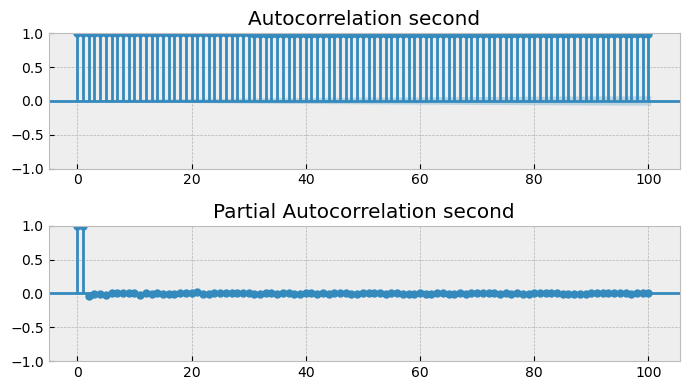

In [61]:
/%python
def acfplot(y, lags=None, figsize = (7,4), style = 'bmh', title_str = ''): 
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,1)
        acf_ax = plt.subplot2grid(layout, (0,0), colspan = 2) 
        pacf_ax = plt.subplot2grid(layout, (1,0)) 
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax,alpha = 0.05)
        acf_ax.set_title('Autocorrelation ' + title_str) 
        pacf_ax.set_title('Partial Autocorrelation ' + title_str) 
        plt.tight_layout()
        plt.show()
    return

acfplot(x_sec_train_AAPL['price'], title_str='second', lags=100)

# p=20, q=3

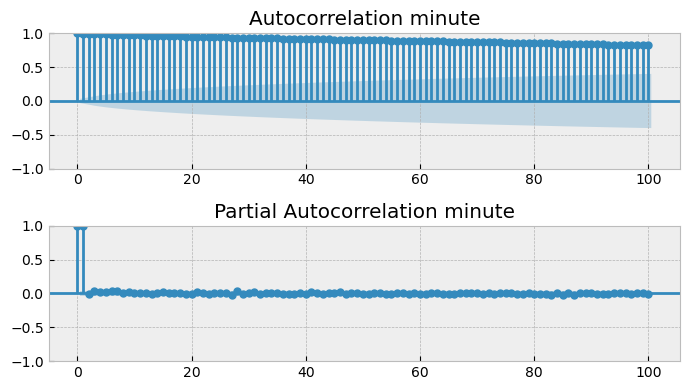

In [62]:
/%python
acfplot(x_min_train_AAPL['price'], title_str='minute', lags=100)
# p=15, q=3

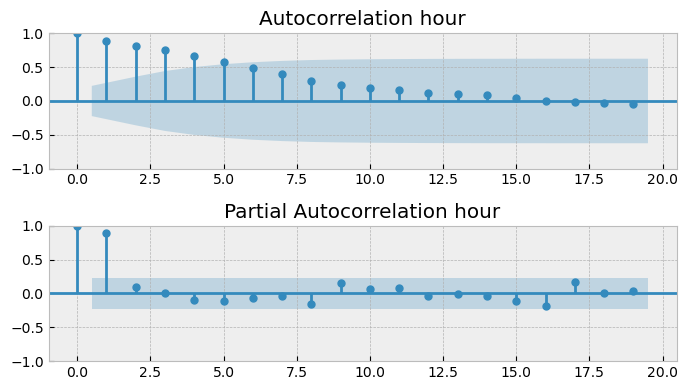

In [63]:
/%python
acfplot(x_hr_train_AAPL['price'], title_str='hour')
# p=6, q=2

In [67]:
/%python
# smt.adfuller(x_sec_train_AAPL['price'])
# The more freqent, the more stationary, no need to run test (takes too long)

In [64]:
/%python
print(smt.adfuller(x_min_train_AAPL['price']))

(-3.489153534022033, 0.00827006309685015, 2, 3904, {'1%': -3.4320261283054165, '5%': -2.8622806217099837, '10%': -2.567164241679929}, -147.7228729468079)


In [65]:
/%python
print(smt.adfuller(x_hr_train_AAPL['price']))

(-2.792597247508496, 0.05933900387639209, 0, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, 201.4787521274814)


#### Second level

In [80]:
/%python
model_sec = smt.ARIMA(x_sec_train_AAPL['price'], order=(20,0,3))
results_sec = model_min.fit()
print(results_sec.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3907
Model:                ARIMA(15, 0, 3)   Log Likelihood                  36.184
Date:                Sat, 09 Dec 2023   AIC                            -32.368
Time:                        16:18:06   BIC                             93.043
Sample:                             0   HQIC                            12.140
                               - 3907                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.7634     18.025     17.795      0.000     285.435     356.092
ar.L1         -0.1927      0.613     -0.314      0.753      -1.394       1.009
ar.L2          0.0262      0.371      0.071      0.9

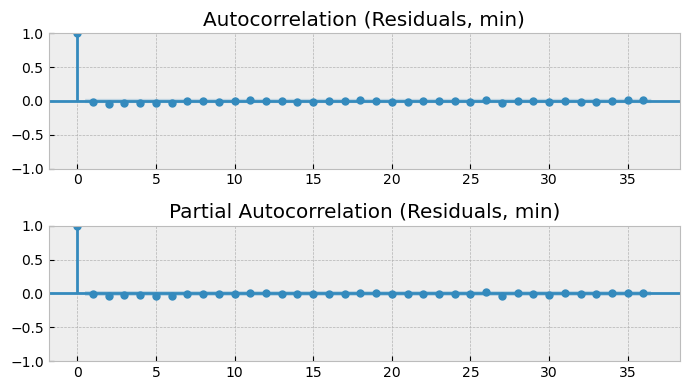

In [81]:
/%python
mod_residuals_sec = results_sec.resid
acfplot(mod_residuals_sec, title_str='(Residuals, min)')

# no significant correlation, suggesting the residuals are just white noise

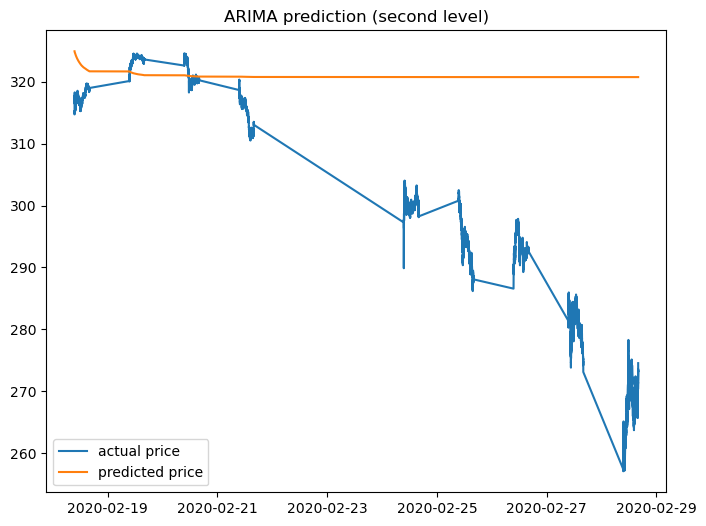

In [85]:
/%python
forecast_sec = results_sec.get_forecast(steps=len(x_sec_test_AAPL))
plt.figure(figsize=(8,6))
plt.plot(x_sec_test_AAPL['price'], label='actual price')
plt.plot(x_sec_test_AAPL.index, forecast_sec.predicted_mean, label='predicted price')
plt.title('ARIMA prediction (second level)')
plt.legend()
plt.show()

#### Minute level

In [68]:
/%python
model_min = smt.ARIMA(x_min_train_AAPL['price'], order=(15,0,3))
results_min = model_min.fit()
print(results_min.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3907
Model:                ARIMA(15, 0, 3)   Log Likelihood                  36.184
Date:                Sat, 09 Dec 2023   AIC                            -32.368
Time:                        15:55:07   BIC                             93.043
Sample:                             0   HQIC                            12.140
                               - 3907                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.7634     18.025     17.795      0.000     285.435     356.092
ar.L1         -0.1927      0.613     -0.314      0.753      -1.394       1.009
ar.L2          0.0262      0.371      0.071      0.9

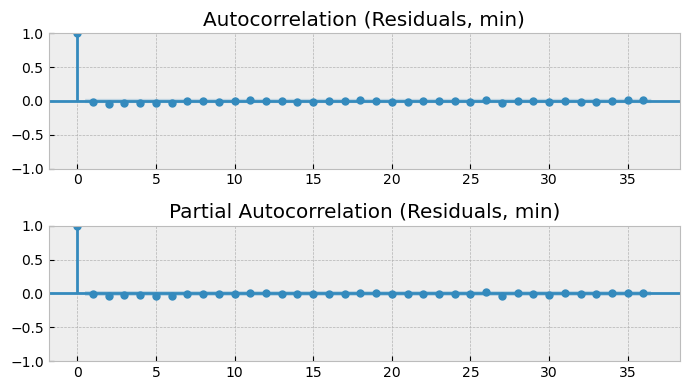

In [69]:
/%python
mod_residuals_min = results_min.resid
acfplot(mod_residuals_min, title_str='(Residuals, min)')

# no significant correlation, suggesting the residuals are just white noise

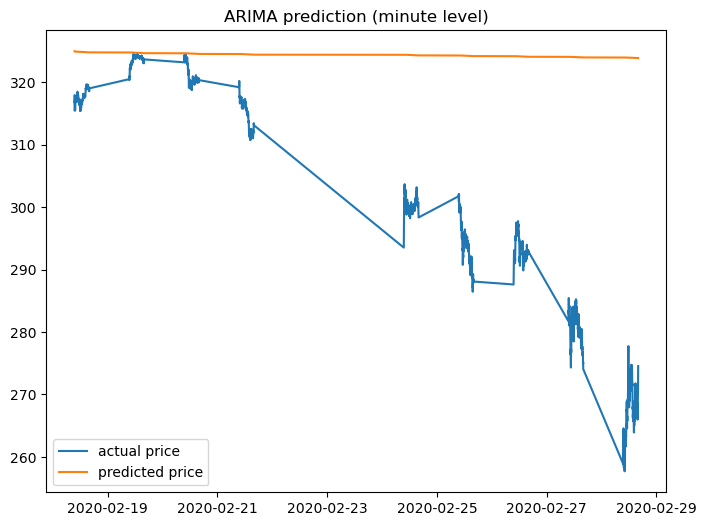

In [90]:
/%python
forecast_min = results_min.get_forecast(steps=len(x_min_test_AAPL))
plt.figure(figsize=(8,6))
plt.plot(x_min_test_AAPL['price'], label='actual price')
plt.plot(x_min_test_AAPL.index, forecast_min.predicted_mean, label='predicted price')
plt.title('ARIMA prediction (minute level)')
plt.legend()
plt.show()

#### Hour level

In [66]:
/%python
model_hr = smt.ARIMA(x_hr_train_AAPL['price'], order=(6,0,2))
results_hr = model_hr.fit()
print(results_hr.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   77
Model:                 ARIMA(6, 0, 2)   Log Likelihood                -141.221
Date:                Sat, 09 Dec 2023   AIC                            302.442
Time:                        15:52:33   BIC                            325.880
Sample:                             0   HQIC                           311.817
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        318.1313      6.398     49.723      0.000     305.591     330.671
ar.L1          0.1985      1.905      0.104      0.917      -3.536       3.933
ar.L2          0.9741      0.234      4.164      0.0

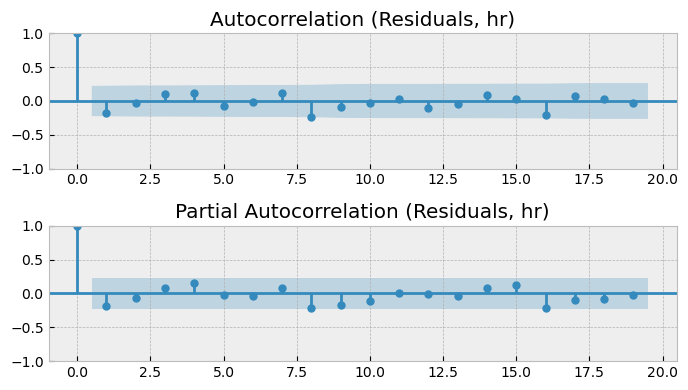

In [70]:
/%python
mod_residuals_hr = results_hr.resid 
acfplot(mod_residuals_hr, title_str='(Residuals, hr)')

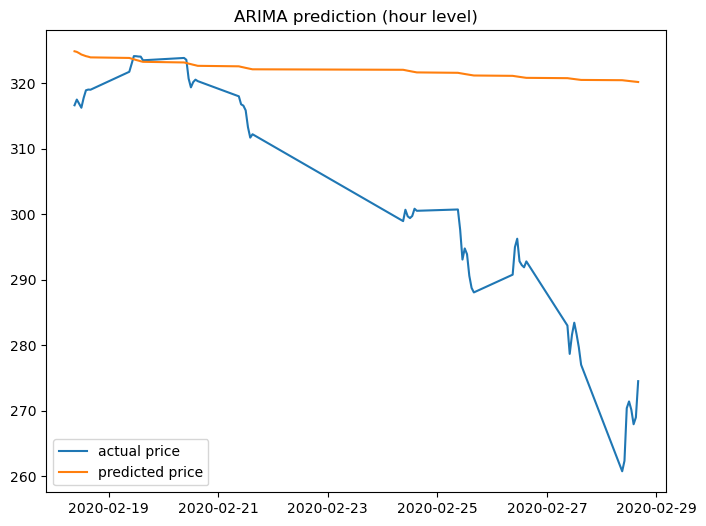

In [89]:
/%python
forecast_hr = results_hr.get_forecast(steps=len(x_hr_test_AAPL))
plt.figure(figsize=(8,6))
plt.plot(x_hr_test_AAPL['price'], label='actual price')
plt.plot(x_hr_test_AAPL.index, forecast_hr.predicted_mean, label='predicted price')
plt.title('ARIMA prediction (hour level)')
plt.legend()
plt.show()

In [ ]:
/%python

In [ ]:
/%python

In [ ]:
/%python

In [ ]:
/%python